In [ ]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 137 images belonging to 6 classes.
Found 34 images belonging to 6 classes.

Training MobileNetV2...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.2084 - loss: 2.0118 - val_accuracy: 0.5000 - val_loss: 1.3834
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4872 - loss: 1.3914 - val_accuracy: 0.6176 - val_loss: 1.1814
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5092 - loss: 1.1002 - val_accuracy: 0.5000 - val_loss: 1.1026
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6547 - loss: 0.9028 - val_accuracy: 0.5588 - val_loss: 1.0220
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7507 - loss: 0.8374 - val_accuracy: 0.6765 - val_loss: 0.9537
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7581 - loss: 0.7154 - val_accuracy: 0.6471 - val_loss: 0.9392
Epoch 7/30
5/5 ━━━━━━━━━

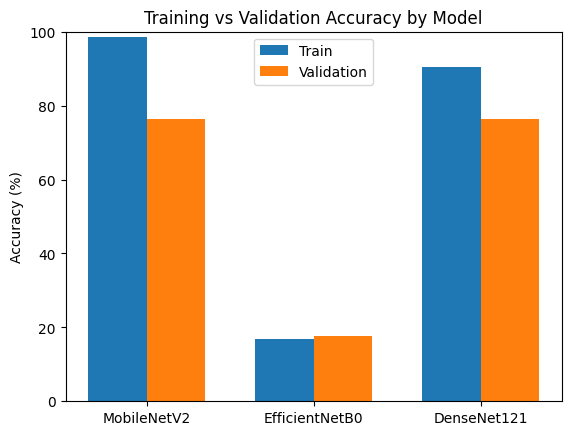

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set paths and parameters
dataset_path = '/content/drive/MyDrive/project/E02/Dataset'
img_height, img_width = 224, 224
batch_size = 32
num_epochs = 30

# Data augmentation and loading
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes

# Function to build model
def build_model(base_model_class):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Models to compare
models = {
    'MobileNetV2': MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'DenseNet121': DenseNet121
}

results = {}

# Training loop
for model_name, base_model in models.items():
    print(f"\nTraining {model_name}...")
    model = build_model(base_model)
    history = model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, verbose=1)

    # Fine-tune
    model.get_layer(index=0).trainable = True
    for layer in model.layers[:100]:
        layer.trainable = False
    for layer in model.layers[100:]:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_fine = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1)

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    print(f"✅ {model_name} Final Training Accuracy: {train_acc*100:.2f}%")
    print(f"✅ {model_name} Final Validation Accuracy: {val_acc*100:.2f}%")

    results[model_name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

# Plotting accuracies
names = list(results.keys())
train_accuracies = [results[n]['train_acc']*100 for n in names]
val_accuracies = [results[n]['val_acc']*100 for n in names]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train')
rects2 = ax.bar(x + width/2, val_accuracies, width, label='Validation')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Training vs Validation Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

plt.ylim(0, 100)
plt.show()


In [ ]:
# Evaluate the models on the training and validation (test) sets
print("\n--- Final Model Evaluation (After Fine-Tuning) ---")
for model_name, data in results.items():
    model = data['model']

    # Evaluate on training data
    train_loss, train_acc = model.evaluate(train_generator, verbose=1)

    # Evaluate on validation data (used as test set)
    val_loss, val_acc = model.evaluate(val_generator, verbose=1)

    print(f"\n📌 {model_name}")
    print(f"✅ Final Training Accuracy: {train_acc * 100:.2f}%")
    print(f"✅ Final Test Accuracy (Validation): {val_acc * 100:.2f}%")

    # Update results dictionary with accurate evaluated values
    results[model_name]['eval_train_acc'] = train_acc
    results[model_name]['eval_val_acc'] = val_acc



--- Final Model Evaluation (After Fine-Tuning) ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9867 - loss: 0.0436
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7898 - loss: 0.7871

📌 MobileNetV2
✅ Final Training Accuracy: 99.27%
✅ Final Test Accuracy (Validation): 79.41%
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1639 - loss: 1.7926
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.1697 - loss: 1.7900

📌 EfficientNetB0
✅ Final Training Accuracy: 17.52%
✅ Final Test Accuracy (Validation): 17.65%
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9945 - loss: 0.1197
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.8499 - loss: 0.5094

📌 DenseNet121
✅ Final Training Accuracy: 99.27%
✅ Final Test Accuracy (Validation): 85.29%


##Save the best model (DenseNet121)

In [ ]:
if model_name == 'DenseNet121':
    model.save('/content/drive/MyDrive/project/E02/best_densenet121_model.keras')

##Make predictions

In [ ]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array_expanded)
    class_idx = np.argmax(prediction)
    confidence = np.max(prediction)

    predicted_label = labels[class_idx]

    print(f"Predicted Class: {predicted_label} (Confidence: {confidence:.2f})")

    # Show the image using matplotlib
    plt.imshow(img)
    plt.title(f"{predicted_label} ({confidence:.2f})")
    plt.axis('off')  # Hide axis
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: Mark Zuckerberg (Confidence: 0.95)


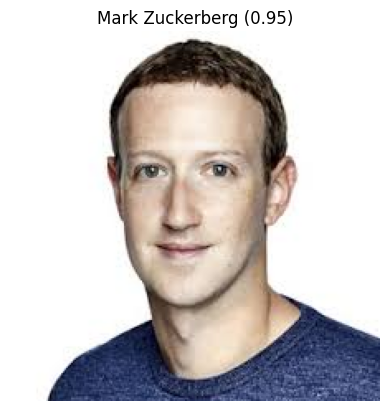

In [ ]:
predict_image('/content/drive/MyDrive/project/E02/test_images/Mark1.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Predicted Class: Steve Jobs (Confidence: 0.99)


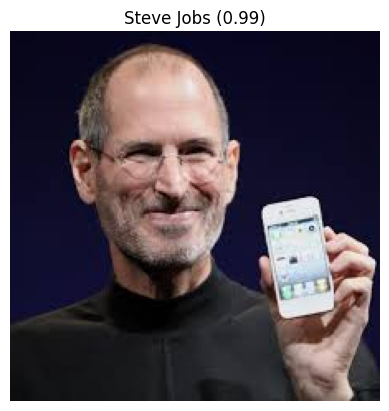

In [ ]:
predict_image('/content/drive/MyDrive/project/E02/test_images/steve.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Predicted Class: Jeff Bezos (Confidence: 0.64)


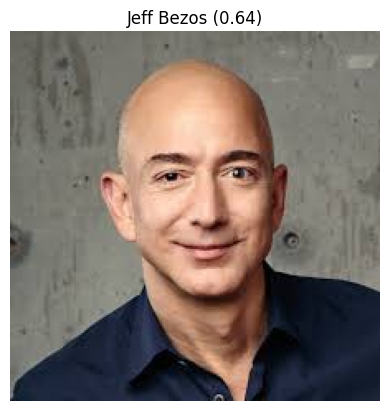

In [ ]:
predict_image('/content/drive/MyDrive/project/E02/test_images/jeff.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted Class: Elon Musk (Confidence: 0.94)


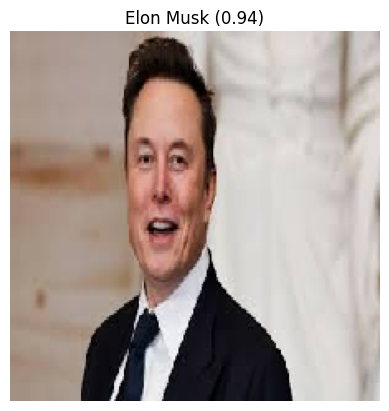

In [ ]:
predict_image('/content/drive/MyDrive/project/E02/test_images/elon.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Predicted Class: Jack Ma (Confidence: 0.61)


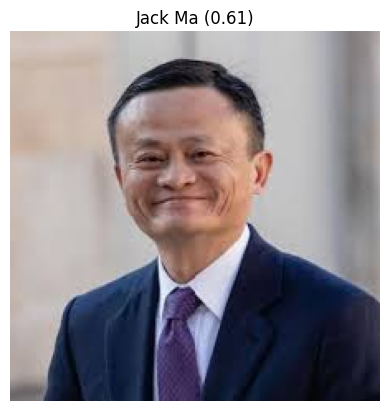

In [ ]:
predict_image('/content/drive/MyDrive/project/E02/test_images/jack.jpeg')

In [ ]:
q